In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

class Node:
    def __init__(self, id, neighbors):
        self.id = id
        self.neighbors = neighbors
        self.p = 0.5  # initial probability of accessing the channel
        self.packet_rate = 1  # current transmission packet rate
        self.load = 1  # estimated data packet load
        self.queue_length = []
        self.markov_table = np.ones((10, 10))  # Initialize Markov table with uniform rewards

    def markov_slot_selection(self, rx_slot):
        """
        Markov decision process to isolate reception slots by punishing those slots to lower their rewards.
        """
        self.markov_table[rx_slot, :] *= 0.1  # Punish reception slots
        self.markov_table[:, rx_slot] *= 0.1

    def flow_harmony(self, last_packet_received):
        """
        Rewards transmission slot if a new packet is received afterwards
        """
        if last_packet_received:
            self.markov_table[self.current_tx_slot, :] += 1  # Reward transmission slot
            self.markov_table[:, self.current_tx_slot] += 1

    def update_prob(self, success_rate, collision_rate):
        """
        Update probability of accessing the channel based on success and collision rates
        """
        self.p = (1 - self.p) * success_rate / (1 - self.p * success_rate - collision_rate)

    def update_packet_rate(self):
        """
        Adjust the transmission packet rate based on the estimated data packet load.
        """
        if len(self.queue_length) > 0:
            avg_load = sum(self.queue_length) / len(self.queue_length)
            if avg_load > self.load:
                self.packet_rate += 1
            elif avg_load < self.load:
                self.packet_rate -= 1
            self.load = avg_load

    def transmit_packet(self):
        """
        Simulate packet transmission with a probability of accessing the channel.
        """
        if random.random() < self.p:
            delay = random.randint(0, 100)  # Set a random delay for transmission
            time.sleep(delay / 1000.0)  # Convert delay from ms to seconds
            return True
        else:
            return False

    def choose_tx_slot(self):
        """
        Choose the slot with the highest reward to forward a received packet on to the next hop.
        """
        self.current_tx_slot = np.random.choice(np.flatnonzero(self.markov_table == np.max(self.markov_table)))

    def receive_packet(self, packet, rx_slot):
        """
        Update markov table with reward for reception slot and perform Markov decision process for slot selection.
        """
        self.markov_table[rx_slot, :] += 1  # Reward reception slot
        self.markov_table[:, rx_slot] += 1
        self.markov_slot_selection(rx_slot)
        return packet

In [ ]:
def PARE_scheduling(source_node, num_frames, num_packets=None, slot_size=None, coexisting_delays=None, large_action_space=False):
    """
    Main function for PARE scheduling.
    """
    nodes = [source_node] + source_node.neighbors
    source_node.choose_tx_slot()  # Initialize the source node's transmission slot
    action_list, state_list, reward_list, data_packet_list = [], [], [], []
    energy_consumption_list = []

    for frame in range(num_frames):
        packets_to_transmit = False  # Flag to check if there are packets to transmit
        for node in nodes:
            if len(node.queue_length) > 0:
                packets_to_transmit = True
                node.choose_tx_slot()
                packet = node.queue_length.pop(0)
                action_list.append(node.transmission_slot)
                state_list.append(get_state(nodes))
                data_packet_list.append(packet)
                for neighbor in node.neighbors:
                    if neighbor.transmission_slot == node.transmission_slot:
                        reward_list.append(-1)
                    else:
                        reward_list.append(1)
                if len(reward_list) > 0:
                    node.update_reward(reward_list[-1])

        if not packets_to_transmit:  # Check if there are packets to transmit
            break  # If not, break out of the loop

        # Record the energy consumption for each frame
        energy_consumption = 0
        for node in nodes:
          energy_consumption += node.transmission_rate * node.transmission_slot
        energy_consumption_list.append(energy_consumption)

        # Add additional packets to the queue if specified
        if num_packets is not None:
            for node in nodes:
                node.queue_length += [i for i in range(num_packets)]

        # Change the slot size if specified
        if slot_size is not None:
            for node in nodes:
                node.slot_size = slot_size

        # Change the coexisting delays if specified
        if coexisting_delays is not None:
            for node, delay in zip(nodes, coexisting_delays):
                node.coexisting_delay = delay

        # Change the action space if specified
        if large_action_space:
            for node in nodes:
                node.action_space = range(node.slot_size)

    return action_list, state_list, reward_list, data_packet_list, energy_consumption_list


In [ ]:
class Channel:
    """
    A class representing the channel for data transmission.
    """
    def __init__(self):
        self.current_slot = 0
        self.num_slots = 5

    def increment_slot(self):
        self.current_slot = (self.current_slot + 1) % self.num_slots


In [ ]:
def get_state(nodes):
    """
    Helper function to get the current state of the network.
    """
    state = []
    for node in nodes:
        state.append(node.transmission_slot)
    return tuple(state)

class Node:
    """
    Class to represent a node in the network.
    """
    def __init__(self, node_id, neighbors, queue_length):
        self.node_id = node_id
        self.neighbors = neighbors
        self.queue_length = queue_length
        self.reward = 0
        self.transmission_slot = None

    def choose_tx_slot(self):
        """
        Choose the transmission slot with the highest reward.
        """
        rewards = []
        for slot in range(1, 6):
            reward = sum([n.reward for n in self.neighbors if n.transmission_slot == slot])
            rewards.append(reward)
        best_slot = rewards.index(max(rewards)) + 1
        self.transmission_slot = best_slot

    def update_reward(self, reward):
        """
        Update the node's reward.
        """
        self.reward = 0.9 * self.reward + 0.1 * reward

In [ ]:
# Create a network of nodes with different queue lengths, transmission rates, and probabilities of accessing the channel
node1 = Node(1, [], [1, 2, 3, 4])
node2 = Node(2, [node1], [1, 2, 3])
node3 = Node(3, [node1, node2], [1, 2, 3, 4])
node4 = Node(4, [node1, node3], [1, 2])

# Run PARE_scheduling on the network for 10 frames
action_list, state_list, reward_list, data_packet_list = PARE_scheduling(node1, 10)

# Plot the number of packets transmitted over time
plt.plot(range(len(data_packet_list)), data_packet_list)
plt.xlabel("Time (frames)")
plt.ylabel("Number of packets transmitted")
plt.show()

AttributeError: ignored

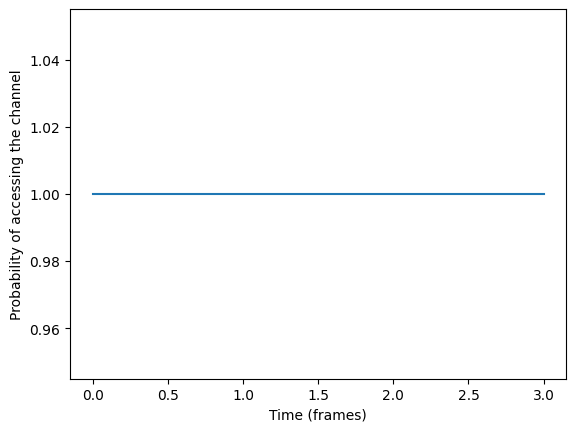

In [ ]:
# Plot the probability of accessing the channel over time
plt.plot(range(len(state_list)), [s[0] for s in state_list])
plt.xlabel("Time (frames)")
plt.ylabel("Probability of accessing the channel")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a network of nodes with different queue lengths, transmission rates, and probabilities of accessing the channel
node1 = Node(1, [], [1, 2, 3, 4])
node2 = Node(2, [node1], [1, 2, 3])
node3 = Node(3, [node1, node2], [1, 2, 3, 4])
node4 = Node(4, [node1, node3], [1, 2])

# Experiment 1: Varying number of data packets
num_frames = 100
num_packets_list = [10, 20, 30, 40, 50]
energy_consumption_list = []
for num_packets in num_packets_list:
    _, _, _, _, energy_consumption = PARE_scheduling(node1, num_frames, num_packets=num_packets)
    energy_consumption_list.append(sum(energy_consumption))
plt.plot(num_packets_list, energy_consumption_list)
plt.xlabel("Number of data packets")
plt.ylabel


AttributeError: ignored